INPUTS
- `sset.PATH_CIAM_COASTLINES_BY_CIAM_SITE`
- `sset.PATH_GADM_ADM1_VORONOI`

OUTPUTS
- `sset.PATH_CIAM_POLYS`
- `sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS`
- `sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS_SHP`

In [77]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pygeos
from shapely.geometry import box

from tqdm.notebook import tqdm

from sliiderss import settings as sset
from sliiderss import spatial as pv

pv.filter_spatial_warnings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
segments = gpd.read_parquet(sset.PATH_CIAM_COASTLINES_BY_CIAM_SITE)

# Compatibility with Voronoi functions
segments = segments.rename(columns={"station_id": "UID"})

segments = segments[~segments.geometry.type.isnull()].copy()

segments = segments.explode(index_parts=False)

In [3]:
segments = segments[~segments["geometry"].is_empty].copy()

In [4]:
segments["geometry"] = pygeos.segmentize(
    pygeos.from_shapely(segments["geometry"]), sset.DENSIFY_TOLERANCE
)

In [5]:
pts, pts_ix = pygeos.get_coordinates(
    pygeos.from_shapely(segments["geometry"]), return_index=True
)

all_pts_df = pd.DataFrame(
    {
        "x": pts[:, 0],
        "y": pts[:, 1],
        "UID": np.take(segments["UID"].to_numpy(), pts_ix),
        "ISO": np.take(segments["ISO"].to_numpy(), pts_ix),
    }
)

all_pts_df = gpd.GeoDataFrame(
    all_pts_df, geometry=gpd.points_from_xy(all_pts_df["x"], all_pts_df["y"])
)

In [6]:
def get_voronoi_from_iso(station_pts):
    station_pts = pv.remove_duplicate_points(station_pts)
    if station_pts["UID"].unique().shape[0] == 1:
        vor_gdf = station_pts.iloc[:1][["UID", "geometry"]].copy()
        vor_gdf["geometry"] = box(-180, -90, 180, 90)
    else:
        if station_pts.shape[0] <= 3:
            poles = pd.DataFrame(
                {
                    "UID": ["northpole", "southpole", "nearsouth"],
                    "y": [90, -90, -89],
                    "x": [0, 0, 0],
                }
            )
            station_pts = pd.concat([station_pts, poles])
        vor_gdf = pv.get_spherical_voronoi_gdf(station_pts, show_bar=False)
        assert np.round(vor_gdf.area.sum(), 0) == 64800

    return vor_gdf


all_isos = all_pts_df["ISO"].unique()
all_isos.sort()

In [7]:
vors = []

for iso in all_isos:
    print(iso, end=" ")
    station_pts = all_pts_df[all_pts_df["ISO"] == iso].copy()
    vors.append(get_voronoi_from_iso(station_pts))

ABW AGO AIA ALA ALB ARE ARG ASM ATF ATG AUS BEL BEN BES BGD BGR BHR BHS BIH BLM BLZ BMU BRA BRB BRN BVT CAN CCK CHL CHN CIV CMR COD COG COK COL COM CPV CRI CUB CUW CXR CYM CYP DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST FIN FJI FLK FRA FRO FSM GAB GBR GEO GGY GHA GIB GIN GLP GMB GNB GNQ GRC GRD GRL GTM GUF GUM GUY HKG HMD HND HRV HTI IDN IMN IND IOT IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KEN KHM KIR KNA KOR KWT LBN LBR LBY LCA LKA LTU LVA MAF MAR MCO MDG MDV MEX MHL MLT MMR MNE MNP MOZ MRT MSR MTQ MUS MYS MYT NAM NCL NFK NGA NIC NIU NLD NOR NRU NZL OMN PAK PAN PCN PER PHL PLW PNG POL PRI PRK PRT PSE PYF QAT REU ROU RUS SAU SDN SEN SGP SGS SHN SJM SLB SLE SLV SOM SPM STP SUR SVN SWE SXM SYC SYR TCA TGO THA TKL TLS TON TTO TUN TUR TUV TWN TZA UKR UMI URY USA VCT VEN VGB VIR VNM VUT WLF WSM XAD XCL XNC XSP YEM ZAF 

In [8]:
vor_gdf = pd.concat(vors, ignore_index=True)

In [11]:
vor_gdf = vor_gdf.join(segments[["UID", "ISO"]].set_index("UID"), on="UID")

In [12]:
assert vor_gdf["ISO"].isnull().sum() == 0

In [13]:
vor_gdf = vor_gdf.dissolve("UID")

In [14]:
vor_gdf = vor_gdf.reset_index(drop=False)

In [15]:
vor_gdf = vor_gdf.rename(columns={"UID": "station_id"})

In [16]:
# vor_gdf.to_parquet(sset.PATH_CIAM_SEGMENTS_GLOBAL_VORONOI_BY_ISO, index=False)

### Calculate Voronoi diagram of all coastal segments, independent of ISO

<AxesSubplot:>

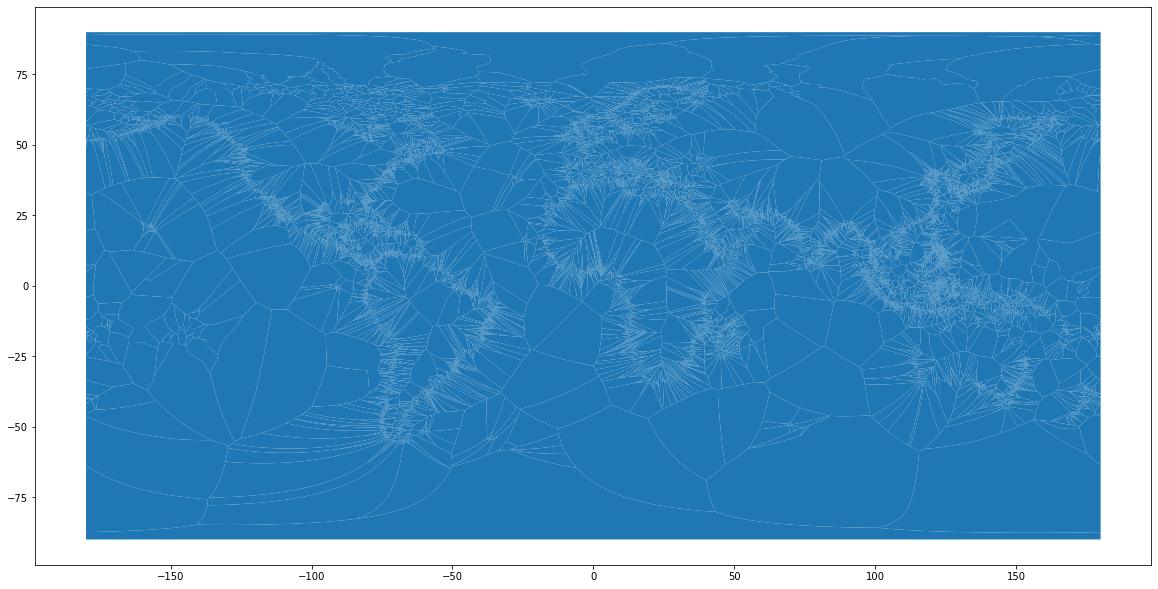

In [17]:
all_stations_vor = get_voronoi_from_iso(all_pts_df)

all_stations_vor.plot(figsize=(20, 20))

In [18]:
all_stations_vor = all_stations_vor.rename(columns={"UID": "station_id"})

## Join ISO-level Voronoi diagrams with country shapes to get final CIAM polygons

In [21]:
coastal_isos = vor_gdf["ISO"].unique()
coastal_isos.sort()

In [22]:
adm1_gdf = gpd.read_parquet(sset.PATH_GADM_ADM1_VORONOI)

In [46]:
adm1_gdf = adm1_gdf.rename(columns={"UID": "adm1"})

In [26]:
coastal_overlays = []

for iso in tqdm(coastal_isos):
    print(iso, end=" ")

    ciam_iso = vor_gdf[vor_gdf["ISO"] == iso].copy()

    adm1_iso = adm1_gdf[adm1_gdf["ISO"] == iso].copy()

    overlay_iso = gpd.overlay(ciam_iso, adm1_iso.drop(columns=["ISO"]))

    coastal_overlays.append(overlay_iso)

  0%|          | 0/207 [00:00<?, ?it/s]

ABW AGO AIA ALA ALB ARE ARG ASM ATF ATG AUS BEL BEN BES BGD BGR BHR BHS BIH BLM BLZ BMU BRA BRB BRN BVT CAN CCK CHL CHN CIV CMR COD COG COK COL COM CPV CRI CUB CUW CXR CYM CYP DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST FIN FJI FLK FRA FRO FSM GAB GBR GEO GGY GHA GIB GIN GLP GMB GNB GNQ GRC GRD GRL GTM GUF GUM GUY HKG HMD HND HRV HTI IDN IMN IND IOT IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KEN KHM KIR KNA KOR KWT LBN LBR LBY LCA LKA LTU LVA MAF MAR MCO MDG MDV MEX MHL MLT MMR MNE MNP MOZ MRT MSR MTQ MUS MYS MYT NAM NCL NFK NGA NIC NIU NLD NOR NRU NZL OMN PAK PAN PCN PER PHL PLW PNG POL PRI PRK PRT PSE PYF QAT REU ROU RUS SAU SDN SEN SGP SGS SHN SJM SLB SLE SLV SOM SPM STP SUR SVN SWE SXM SYC SYR TCA TGO THA TKL TLS TON TTO TUN TUR TUV TWN TZA UKR UMI URY USA VCT VEN VGB VIR VNM VUT WLF WSM XAD XCL XNC XSP YEM ZAF 

In [27]:
coastal_overlays = pd.concat(coastal_overlays, ignore_index=True)

<AxesSubplot:>

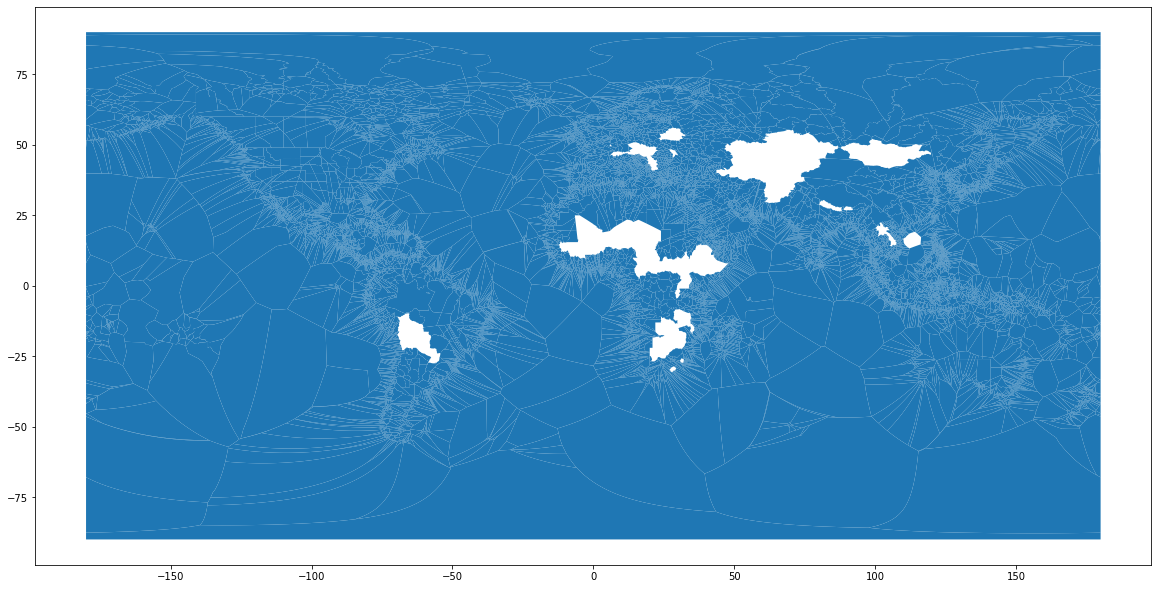

In [28]:
coastal_overlays.plot(figsize=(20, 20))

In [29]:
landlocked_isos = sorted(list(set(adm1_gdf["ISO"].unique()) - set(coastal_isos)))

In [31]:
landlocked_overlays = []
for iso in tqdm(landlocked_isos):
    print(iso, end=" ")

    adm1_iso = adm1_gdf[adm1_gdf["ISO"] == iso].copy()

    overlay_iso = gpd.overlay(all_stations_vor, adm1_iso)

    landlocked_overlays.append(overlay_iso)

  0%|          | 0/47 [00:00<?, ?it/s]

AFG AND ARM AUT AZE BDI BFA BLR BOL BTN BWA CAF CHE CZE ETH HUN KAZ KGZ LAO LIE LSO LUX MAC MDA MKD MLI MNG MWI NER NPL PRY RWA SMR SRB SSD SVK SWZ TCD TJK TKM UGA UZB VAT XKO XPI ZMB ZWE 

In [32]:
landlocked_overlays = pd.concat(landlocked_overlays, ignore_index=True)

<AxesSubplot:>

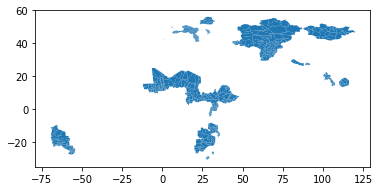

In [33]:
landlocked_overlays.plot()

In [34]:
landlocked_overlays.area.sum() + coastal_overlays.area.sum()

64799.97446542215

In [35]:
all_overlays = pd.concat([landlocked_overlays, coastal_overlays], ignore_index=True)

<AxesSubplot:>

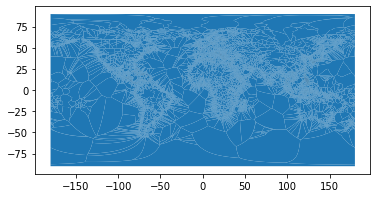

In [36]:
all_overlays.plot()

In [37]:
assert all_overlays.is_valid.all()

In [38]:
%%time
all_overlays = pv.fill_in_gaps(all_overlays)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 2min 35s, sys: 14.5 ms, total: 2min 35s
Wall time: 2min 35s


In [51]:
all_overlays["seg_adm"] = (
    "seg_"
    + all_overlays["station_id"].str.split("_").str[-1]
    + "_adm1_"
    + all_overlays["adm1"].astype(str)
)

In [53]:
from glo_co import settings as pset

ps = pset.Settings()

In [86]:
sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS.parent.mkdir(exist_ok=False)

In [87]:
all_overlays.to_parquet(sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS, index=False)

In [88]:
all_overlays.to_file(sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS_SHP)

<AxesSubplot:>

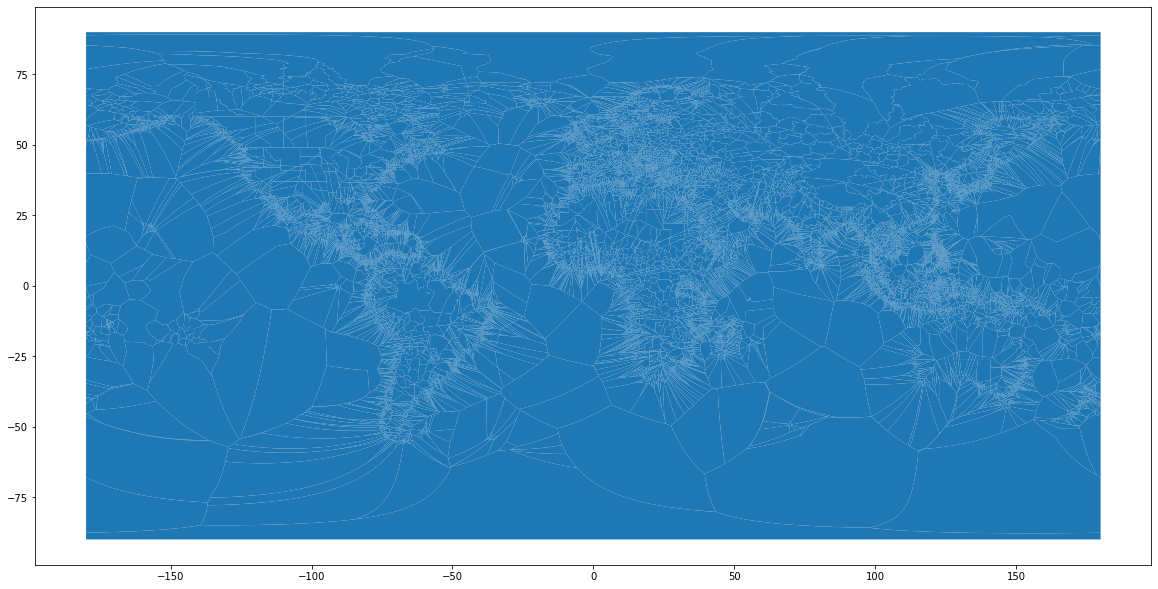

In [58]:
all_overlays.plot(figsize=(20, 20))

In [64]:
ciam_polys = all_overlays.dissolve("station_id", as_index=False).drop(
    columns=["adm1", "seg_adm"]
)

<AxesSubplot:>

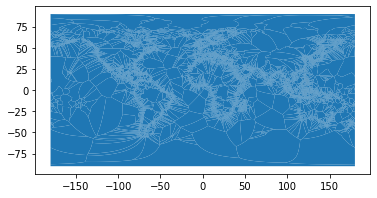

In [66]:
ciam_polys.plot()

In [71]:
ciam_polys["geometry"] = ciam_polys["geometry"].apply(pv.strip_line_interiors)

ciam_polys.interiors.str.len().sum()

In [79]:
assert ciam_polys.is_valid.all()

In [75]:
ciam_polys.area.sum()

64800.00788240073

In [91]:
ciam_polys.to_parquet(sset.PATH_CIAM_POLYS, index=False)